In [28]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from configs import utils
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_tbl_cols(-1)

lf_dog_move_data = utils.load_large_data("../data/raw", "DogMoveData.csv", schema=utils.dog_move_data_schema)

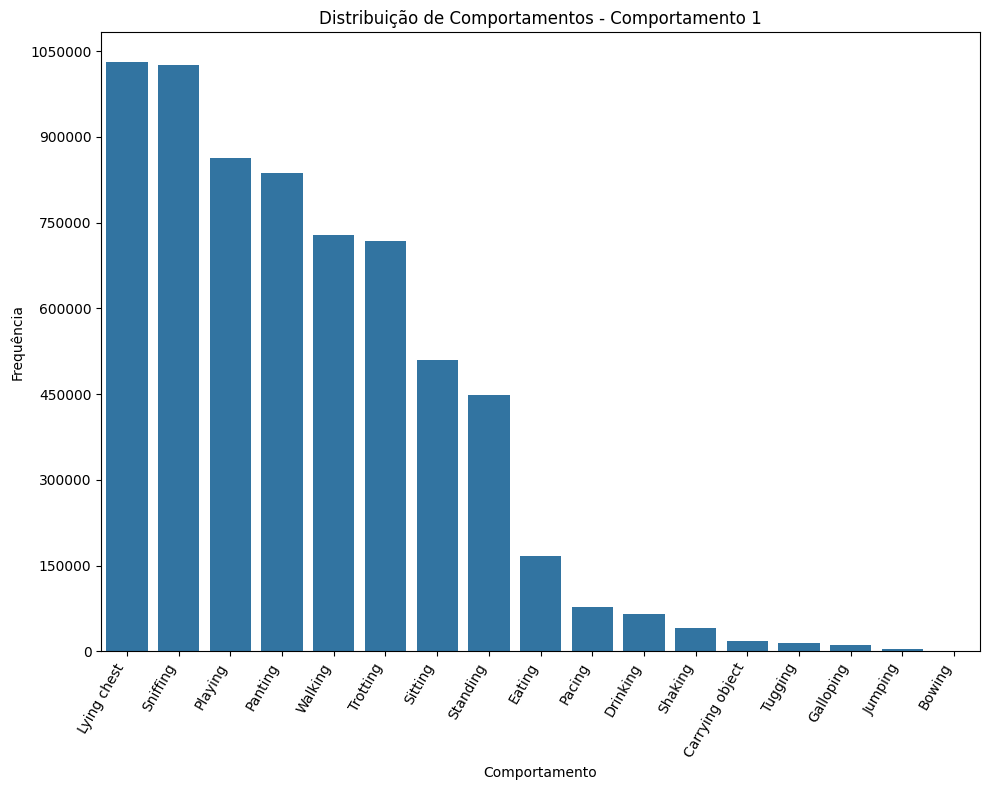

In [21]:
from matplotlib.ticker import MaxNLocator, StrMethodFormatter

p_behavior_1_count = lf_dog_move_data.select(
    pl.col("Behavior_1")
    .filter(
        pl.col("Behavior_1").is_not_null() &
        ~pl.col("Behavior_1").is_in(["<undefined>", "Synchronization", "Extra_Synchronization"]) 
    )
    .value_counts()
)

behavior_1_count = p_behavior_1_count.unnest("Behavior_1").collect().sort("count", descending=True)

labels = behavior_1_count["Behavior_1"].to_list()
counts = behavior_1_count["count"].to_list()

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=counts, x=labels, orient="v")
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

plt.xticks(rotation=60, ha='right')
plt.title("Distribuição de Comportamentos - Comportamento 1")
plt.xlabel("Comportamento")
plt.ylabel("Frequência")
plt.tight_layout()
plt.savefig("../reports/figures/distribuicao_comportamentos.png")
plt.show()

In [ ]:
p_behavior_usage = (
    lf_dog_move_data
    .select(
        pl.len().alias("Total_Registros"),
        
        pl.col("Behavior_2")
        .filter(pl.col("Behavior_2") != "<undefined>")
        .len()
        .alias("Uso_Behavior_2"),
        
        pl.col("Behavior_3")
        .filter(pl.col("Behavior_3") != "<undefined>")
        .len()
        .alias("Uso_Behavior_3")
    )
)

df_usage_counts = p_behavior_usage.collect()
print(df_usage_counts)

total = df_usage_counts.item(0, "Total_Registros")
uso_b2 = df_usage_counts.item(0, "Uso_Behavior_2")
uso_b3 = df_usage_counts.item(0, "Uso_Behavior_3")

print(f"\nBehavior_2 é preenchido em: { (uso_b2 / total) * 100 :.2f}% dos registros.")
print(f"Behavior_3 é preenchido em: { (uso_b3 / total) * 100 :.2f}% dos registros.")


--- Utilização das Colunas de Comportamento Secundário ---
shape: (1, 3)
┌─────────────────┬────────────────┬────────────────┐
│ Total_Registros ┆ Uso_Behavior_2 ┆ Uso_Behavior_3 │
╞═════════════════╪════════════════╪════════════════╡
│ 10611068        ┆ 2977384        ┆ 201084         │
└─────────────────┴────────────────┴────────────────┘

Behavior_2 é preenchido em: 28.06% dos registros.
Behavior_3 é preenchido em: 1.90% dos registros.


In [29]:
p_combinations = (
    lf_dog_move_data
    .filter(pl.col("Behavior_2") != "<undefined>")
    .group_by(["Behavior_1", "Behavior_2"])
    .agg(pl.len().alias("Frequencia"))
    .sort(by="Frequencia", descending=True)
)

df_combinations = p_combinations.collect()

with pl.Config(tbl_rows=-1, tbl_cols=-1, fmt_str_lengths=200):
    print(df_combinations.head(15))

shape: (15, 3)
┌─────────────┬─────────────────┬────────────┐
│ Behavior_1  ┆ Behavior_2      ┆ Frequencia │
╞═════════════╪═════════════════╪════════════╡
│ Lying chest ┆ Panting         ┆ 555058     │
│ Panting     ┆ Sitting         ┆ 437303     │
│ Panting     ┆ Standing        ┆ 368580     │
│ Playing     ┆ Tugging         ┆ 236528     │
│ Sitting     ┆ Panting         ┆ 215898     │
│ Standing    ┆ Panting         ┆ 169914     │
│ <undefined> ┆ Sitting         ┆ 124876     │
│ <undefined> ┆ Standing        ┆ 124588     │
│ Playing     ┆ Carrying object ┆ 120183     │
│ Eating      ┆ Standing        ┆ 80579      │
│ Playing     ┆ Galloping       ┆ 75866      │
│ Lying chest ┆ Eating          ┆ 59747      │
│ Eating      ┆ Sitting         ┆ 48525      │
│ <undefined> ┆ Lying chest     ┆ 46770      │
│ <undefined> ┆ Playing         ┆ 42121      │
└─────────────┴─────────────────┴────────────┘


In [30]:
# faça um frame com todos os comportamentos
all_behaviors = lf_dog_move_data.select(
    pl.col("Behavior_1"),
    pl.col("Behavior_2"),
    pl.col("Behavior_3")
)

all_behaviors = all_behaviors.collect()